# Chapter 7 Practice Answers

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
from watermark import watermark

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark

Last updated: 2024-07-03T09:03:08.204113-04:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
%watermark --iversions

numpy     : 1.25.2
matplotlib: 3.8.2
pandas    : 2.1.3
pymc      : 5.9.2
arviz     : 0.16.1



# 7E1 Question State the three motivating criteria that define information entropy. Try to express each in your own words.


7E1
1. The measure of uncertainity should be continuous.
1. An increase in number of events should increase uncernaity 
1. The measure of uncernaity should be additive.  It's the sum of the invidual uncertanities

# 7E2 Question
Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads 70% of the time. What is the entropy of this coin?


In [4]:
def calc_entropy(values):
    np_values = np.array(values)
    return np.round(-np.sum(np_values * np.log(np_values)),2)

In [5]:
calc_entropy([0.7,0.3])

0.61

# 7E3 Question
 Suppose a four-sided die is loaded such that, when tossed onto a table, it shows “1” 20%, “2” 25%, “3” 25%, and “4” 30% of the time. What is the entropy of this die?

In [6]:
#7E3
calc_entropy([.2,.25,.25,.3])

1.38

# 7E4 Question
 Suppose another four-sided die is loaded such that it never shows “4”. The other three sides show equally often. What is the entropy of this die

In [7]:
calc_entropy([.33,.33,.33])

1.1

# 7M1 Question 
Write down and compare the definitions of AIC and WAIC. Which of these criteria is most general? Which assumptions are required to transform the more general criterion into a less general one?

7M1 Answer: AIC and WAIC are both information criteria that use pointwise calculations, but WAIC has a different pentality term.  WAIC is more widely applicable becauese it does not make any assumptions about the priors, the posterior.  AIC assumes flat priors and a multivariate gaussian posterior

# 7M2 Question 
Explain the difference between model selection and model comparison. What information is lost under model selection?

Model selection is when you select a model based purely on some information criteria such as predictive accuracy.  However, when picking models like this, you throw away other information such as information about casuality.  More complex models tend to have lower scores in such criteria, so they always win.

Model comparison allows to explore causality and how the predictors drive prediction.  So we are not throwing away information

# 7M3 Question
When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values, if the models were fit to different numbers of observations? Perform some experiments, if you are not sure.


In [8]:
#All information criteria use the lppd, which is the average of a pointwise calculation.  
#So if we change the number of datapoints, this actually changes the lppd, which means we cannot
#compare models using information criteria if the points are different.

#Simulation
n = 100
intercept = 10,
x_values = np.random.normal(10,2,n)
y_values = intercept + (.5*x_values) + 0.1*np.random.normal(5,1,n)

output_vals = []
#Simulate training a model with an increasing number of datapoints removed from the training data
for i in [98,99,100]:
    with pm.Model() as m_7m3:
        a = pm.Normal('a', 10, 1)
        b = pm.Normal('b', 5,3)
        sigma = pm.Exponential('sigma',1)
        mu = pm.Deterministic('mu',a + b*x_values[0:i])
        y = pm.Normal('y', mu, sigma, observed=y_values[0:i])
        m_7m3_trace = pm.sample(idata_kwargs={"log_likelihood": True}) 
        waic_output = az.waic(m_7m3_trace, pointwise=True, scale='deviance')
        b_estimate = az.summary(m_7m3_trace, var_names='b').mean()
    output_vals.append((i, waic_output.elpd_waic, b_estimate['mean'], b_estimate['sd']))
    #print(f'Len: {i}, WAIC {waic_output.elpd_waic}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [9]:
#The 2nd value in the tuple is the WAIC score, 3rd the estimate for b, and the last is the se for b.
#Despite all the models having a good esimate for B, the WAIC score is increasing based on the 
#number of samples (the first value in the tuple).  This is because WAIC goes up based on sample size, 
#so models with different sample sizes should not be compared.
output_vals

[(98, -177.83548978307897, 0.503, 0.005),
 (99, -178.84402257637578, 0.503, 0.006),
 (100, -181.86564172087745, 0.503, 0.005)]

# 7M4 Question
 What happens to the effective number of parameters, as measured by PSIS or WAIC, as a prior becomes more concentrated? Why? Perform some experiments, if you are not sure.

In [10]:
#Simulation
n = 100
intercept = 10,
x1_values = np.random.normal(0,1,n)
x2_values = np.random.normal(0,1,n)
x3_values = np.random.normal(0,1,n)
y_values = intercept + (0.35*x1_values) + (.45*x2_values) + (.55*x3_values) + np.random.normal(0,1,n)

output_vals = []
#Simulate shrinking the standard deviation in the b priors
for i in [3,1,0.1]:
    with pm.Model() as m_7m4:
        a = pm.Normal('a', 5, 2)
        b1 = pm.Normal('b1', 0,i)
        b2 = pm.Normal('b2', 0,i)
        b3 = pm.Normal('b3', 0,i)
        sigma = pm.Exponential('sigma',1)
        mu = pm.Deterministic('mu',a + b1*x1_values + b2*x2_values + b3*x2_values)
        y = pm.Normal('y', mu, sigma, observed=y_values)
        m_7m4_trace= pm.sample(idata_kwargs={"log_likelihood": True}) 
        waic_output = az.waic(m_7m4_trace, pointwise=True, scale='deviance')
        b_estimate = az.summary(m_7m4_trace, var_names=['b1','b2','b3'])
    output_vals.append((i, waic_output.p_waic, b_estimate['mean']['b1'], b_estimate['sd']['b1'],
                       b_estimate['mean']['b2'], b_estimate['sd']['b2'],
                       b_estimate['mean']['b3'], b_estimate['sd']['b3']))
    #print(f'Len: {i}, WAIC {waic_output.elpd_waic}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, b3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, b3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, b3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [11]:
#As the priors become stronger, the effective number of paramters should decrease.  This is because the penalty 
#term for WAIC uses a variance term, and with strong priors the possible variance in the posterior is decreased.
#The second value in the tuple is the number of effective paramters
output_vals

[(3, 4.101006822703578, 0.454, 0.122, 0.154, 2.173, 0.231, 2.174),
 (1, 4.050452902122086, 0.448, 0.122, 0.172, 0.696, 0.205, 0.697),
 (0.1, 3.065083279264359, 0.174, 0.081, 0.106, 0.086, 0.106, 0.085)]

# 7M5 Question
 Provide an informal explanation of why informative priors reduce overfitting.

Informative Priors constrain the parameter space and act as a regularization method.  It contrains the parameters to resonable general values, and not a value specific to our sample 

# 7M6 Question
 Provide an informal explanation of why overly informative priors result in underfitting.


Overly Informative priors constrain the paramter space too much, limiting the paramter values, which results in underfitting.  We essentially get back our priors instead of the parameters fit to the data

# 7H1 Question
In 2007, The Wall Street Journal published an editorial (“We’re Number One, Alas”) with a graph of corporate tax rates in 29 countries ploted against tax revenue. A badly fit curve was drawn in (reconstructed at right), seemingly by hand, to make the argument that the relationship between tax rate and tax revenue increases and then declines, such that higher tax rates can actually produce less tax revenue. I want you to actally fit a curve to these data, found in data(Laffer). Consider models that use tax rate to predict tax revenue. Compare, using WAIC or PSIS, a straight-line model to any curved models you like. What do you conclude about the relationship between tax rate and tax revenue?


In [12]:
laffer = pd.read_csv('.\data\Laffer.csv', sep=';')

<Axes: xlabel='tax_rate', ylabel='tax_revenue'>

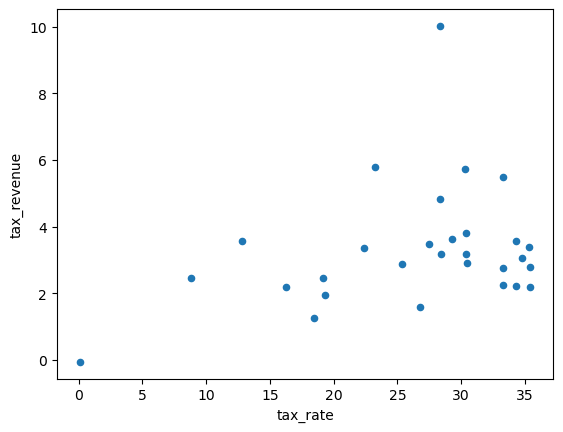

In [13]:
laffer.plot.scatter(x='tax_rate',y='tax_revenue')

In [14]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [15]:
laffer['tax_rate_std'] = standardize(laffer['tax_rate'])
laffer['tax_revenue_std'] = standardize(laffer['tax_revenue'])
laffer.shape

(29, 4)

In [16]:
laffer2 = laffer[laffer['tax_revenue'] < 10]

In [17]:
with pm.Model() as m_7h1_a:
        a = pm.Normal('a', 0, .5)
        b1 = pm.Normal('b1', 0, .5)
        x_values = pm.Data('x_values', laffer['tax_rate_std'])
        y_values = pm.Data('y_values', laffer['tax_revenue_std'])
        sigma = pm.Exponential('sigma',1)
        mu = pm.Deterministic('mu',a + b1*x_values)
        y = pm.Normal('y', mu, sigma, observed=y_values)
        m_7h1_a_trace = pm.sample(idata_kwargs={"log_likelihood": True}) 

with pm.Model() as m_7h1_b:
        a = pm.Normal('a', 0, .5)
        b1 = pm.Normal('b1', 0, .5)
        b2 = pm.Normal('b2', 0, .5)
        x_values = pm.Data('x_values', laffer['tax_rate_std'])
        y_values = pm.Data('y_values', laffer['tax_revenue_std'])
        sigma = pm.Exponential('sigma',1)
        mu = pm.Deterministic('mu',a + b1*x_values + b2*x_values**2)
        y = pm.Normal('y', mu, sigma, observed=y_values)
        m_7h1_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_7h1_c:
        a = pm.Normal('a', 0, .5)
        b1 = pm.Normal('b1', 0,.5)
        b2 = pm.Normal('b2', 0,.5)
        b3 = pm.Normal('b3', 0,.5)
        x_values = pm.ConstantData('x_values', laffer['tax_rate_std'])
        sigma = pm.Exponential('sigma',1)
        mu = pm.Deterministic('mu',a + b1*x_values + b2*x_values**2 + b3*x_values**3)
        y = pm.Normal('y', mu, sigma, observed=laffer['tax_revenue_std'])
        m_7h1_c_trace = pm.sample(idata_kwargs={"log_likelihood": True})

d:\Python\venv\pymc_env\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
d:\Python\venv\pymc_env\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, b3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


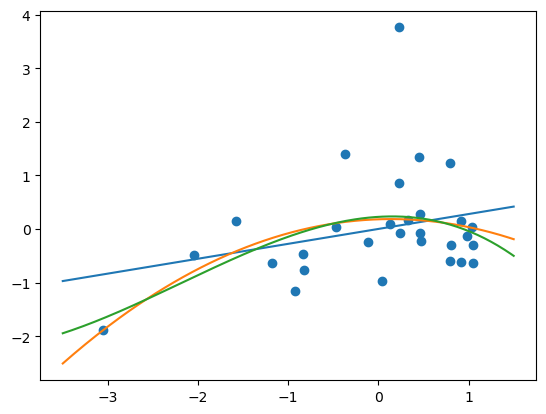

In [18]:
x_axis_points = np.linspace(-3.5,1.5, 200)
y_model_1 = m_7h1_a_trace['posterior']['a'].mean().item(0) + m_7h1_a_trace['posterior']['b1'].mean().item(0) * x_axis_points

y_model_2 = (m_7h1_b_trace['posterior']['a'].mean().item(0) + 
             m_7h1_b_trace['posterior']['b1'].mean().item(0) * x_axis_points +  
             m_7h1_b_trace['posterior']['b2'].mean().item(0) * x_axis_points**2)

y_model_3 = (m_7h1_c_trace['posterior']['a'].mean().item(0) + 
             m_7h1_c_trace['posterior']['b1'].mean().item(0) * x_axis_points +  
             m_7h1_c_trace['posterior']['b2'].mean().item(0) * x_axis_points**2  + 
             m_7h1_c_trace['posterior']['b3'].mean().item(0) * x_axis_points**3)

plt.scatter(laffer['tax_rate_std'],laffer['tax_revenue_std'])
plt.plot(x_axis_points,y_model_1)
plt.plot(x_axis_points,y_model_2)
plt.plot(x_axis_points,y_model_3)

In [19]:
compare_data = az.compare({'1_paramter':m_7h1_a_trace,
            '2_parameter':m_7h1_b_trace,
            '3_parameter':m_7h1_c_trace},
           scale='deviance',
           ic='loo'
          )
compare_data

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Est

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
2_parameter,0,87.433804,5.640842,0.000000,1.000000e+00,19.287742,0.000000,True,deviance
3_parameter,1,88.186092,6.088549,0.752288,5.551115e-17,18.650627,1.223529,True,deviance
1_paramter,2,88.606537,5.187681,1.172733,0.000000e+00,18.787082,1.599848,True,deviance


d:\Python\venv\pymc_env\lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

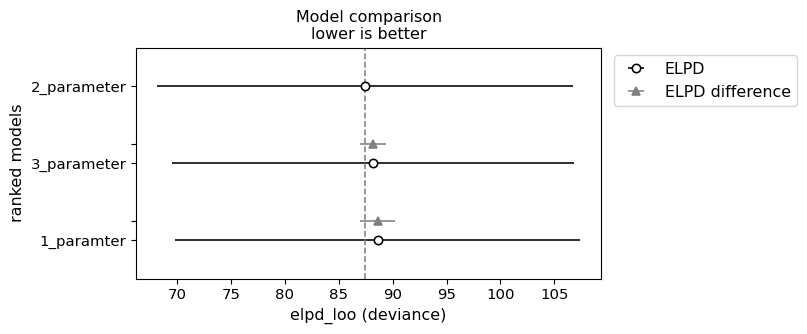

In [20]:
az.plot_compare(compare_data)

Looking at the scores, we can see that the 2 parameter model (not including intercept) is only slightly better than the 1 parameter model, but the 3 parameter model is starting to overfit because it is worse than the model with only one beta parameter

# 7H2 Question
In the Laffer data, there is one country with a high tax revenue that is an outlier. Use PSIS and WAIC to measure the importance of this outlier in the models you fit in the previous problem. Then use robust regression with a Student’s t distribution to revisit the curve fitting problem. How much does a curved relationship depend upon the outlier point?

In [21]:
#7h2
with pm.Model() as m_7h2_a:
        a = pm.Normal('a', 0, .5)
        b1 = pm.Normal('b1', 0, .5)
        b2 = pm.Normal('b2', 0, .5)
        x_values = pm.Data('x_values', laffer['tax_rate_std'])
        y_values = pm.Data('y_values', laffer['tax_revenue_std'])
        sigma = pm.Exponential('sigma',1)
        mu = pm.Deterministic('mu',a + b1*x_values + b2*x_values**2)
        y = pm.Normal('y', mu, sigma, observed=y_values)
        m_7h2_a_trace = pm.sample(idata_kwargs={"log_likelihood": True})

d:\Python\venv\pymc_env\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [22]:
m_7h2_a_waic = az.waic(m_7h2_a_trace, scale='deviance', pointwise=True)
m_7h2_a_waic

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 29 observations log-likelihood matrix.

              Estimate       SE
deviance_waic    86.29    18.36
p_waic            5.09        -

There has been a warning during the calculation. Please check the results.

In [23]:
m_7h2_a_loo = az.loo(m_7h2_a_trace, scale='deviance', pointwise=True)

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [24]:
m_7h2_a_loo

Computed from 4000 posterior samples and 29 observations log-likelihood matrix.

             Estimate       SE
deviance_loo    86.78    18.73
p_loo            5.33        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       28   96.6%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    3.4%
   (1, Inf)   (very bad)    0    0.0%

In [25]:
m_7h2_a_loo.pareto_k

<xarray.DataArray 'pareto_shape' (y_dim_0: 29)>
array([ 0.46047488,  0.15070858,  0.04599032,  0.11499636,  0.14479146,
        0.11331706,  0.17006128,  0.14952384, -0.03812417,  0.02921537,
        0.29433922,  0.83374947,  0.01815832,  0.05211245, -0.10839619,
       -0.09149716, -0.11620362, -0.06567784, -0.00972973, -0.07961592,
       -0.12156637, -0.06734321,  0.01304278,  0.00821642, -0.03468754,
        0.11527623,  0.15689383,  0.199059  ,  0.13222712])
Coordinates:
  * y_dim_0  (y_dim_0) int32 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28

In [26]:
laffer[m_7h2_a_loo.pareto_k.values > .7]

,tax_rate,tax_revenue,tax_rate_std,tax_revenue_std
11,28.32,10.02,0.225306,3.761445


We can see in the k values above, the extreme values in the original data

In [27]:
with pm.Model() as m_7h2_b:
        a = pm.Normal('a', 0, .5)
        b1 = pm.Normal('b1', 0, .5)
        b2 = pm.Normal('b2', 0, .5)
        x_values = pm.Data('x_values', laffer['tax_rate_std'])
        y_values = pm.Data('y_values', laffer['tax_revenue_std'])
        sigma = pm.Exponential('sigma',1)
        mu = pm.Deterministic('mu',a + b1*x_values + b2*x_values**2)
        y = pm.StudentT('y', nu=2, mu=mu, sigma=sigma, observed=y_values)
        m_7h2_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})

d:\Python\venv\pymc_env\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [28]:
az.waic(m_7h2_b_trace, scale='deviance', pointwise=True)

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 29 observations log-likelihood matrix.

              Estimate       SE
deviance_waic    72.36    12.44
p_waic            3.78        -

There has been a warning during the calculation. Please check the results.

In [29]:
m_7h2_b_loo = az.loo(m_7h2_b_trace, scale='deviance', pointwise=True)

In [30]:
m_7h2_b_loo

Computed from 4000 posterior samples and 29 observations log-likelihood matrix.

             Estimate       SE
deviance_loo    72.54    12.44
p_loo            3.87        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       29  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

With the Student T distribution, the extreme values are no longer triggering a warning

d:\Python\venv\pymc_env\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


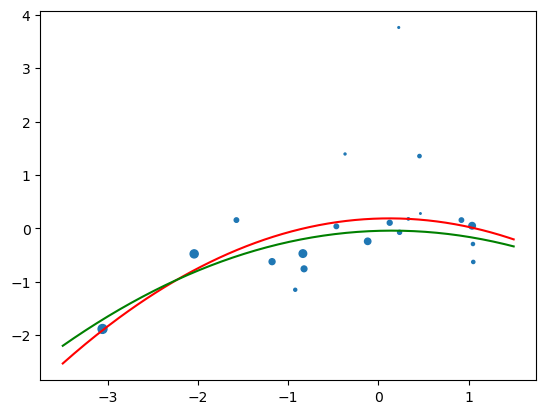

In [31]:
x_axis_points = np.linspace(-3.5,1.5, 200)

y_model_1 = (m_7h2_a_trace['posterior']['a'].mean().item(0) + 
             m_7h2_a_trace['posterior']['b1'].mean().item(0) * x_axis_points +  
             m_7h2_a_trace['posterior']['b2'].mean().item(0) * x_axis_points**2)

y_model_2 = (m_7h2_b_trace['posterior']['a'].mean().item(0) + 
             m_7h2_b_trace['posterior']['b1'].mean().item(0) * x_axis_points +  
             m_7h2_b_trace['posterior']['b2'].mean().item(0) * x_axis_points**2)

plt.scatter(laffer['tax_rate_std'],laffer['tax_revenue_std'], s=m_7h2_b_loo.pareto_k.values*100)
plt.plot(x_axis_points,y_model_1, label='Gaussian', color='r')
plt.plot(x_axis_points,y_model_2, label='Student T', color='g')

In [32]:
np.min(m_7h2_a_loo.pareto_k.values),np.max(m_7h2_a_loo.pareto_k.values)

(-0.12156636599847917, 0.8337494679751712)

In [33]:
m_7h2_b_loo.pareto_k.values[m_7h2_a_loo.pareto_k.values > .7]

array([0.01527014])

With the Student T distribution, the more extreme values are having less influence than some of the values closed to the fitted curve.

In [34]:
compare_data_7h2 = az.compare({'2_Gaussian':m_7h1_b_trace,
            '2_StudentT':m_7h2_b_trace},
           scale='deviance',
           ic='loo'
          )
compare_data_7h2

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, plea

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
2_StudentT,0,72.541674,3.867891,0.000000,0.874223,12.444840,0.000000,False,deviance
2_Gaussian,1,87.433804,5.640842,14.892131,0.125777,19.287742,11.620284,True,deviance


d:\Python\venv\pymc_env\lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

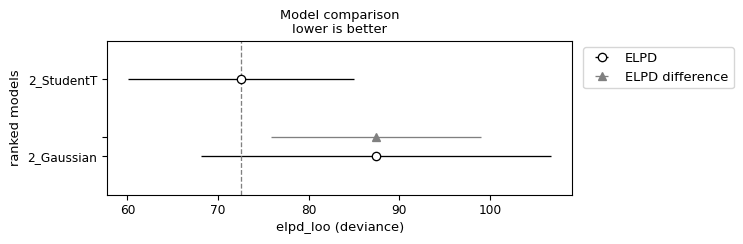

In [35]:
az.plot_compare(compare_data_7h2)

# 7H3 Question
 Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the bird population. They have each found the following proportions of 5 important bird species:  (You can see the data in the dataframe in the next cell). Notice that each row sums to 1, all the birds. This problem has two parts. It is not computationally complicated. But it is conceptually tricky. First, compute the entropy of each island’s bird distribution. Interpret these entropy values. Second, use each island’s bird distribution to predict the other two. This means to compute the KL divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different KL divergence values. Which island predicts the others best? Why?

In [36]:
island_data = pd.DataFrame({'Species A': [0.2, 0.8,0.05],
               'Species B': [0.2, 0.1,0.15],
              'Species C': [0.2, 0.05,0.7],
              'Species D': [0.2, 0.025,0.05],
              'Species E': [0.2, 0.025,0.05]})
island_data.index = ['Island 1','Island 2','Island 3']
island_data

,Species A,Species B,Species C,Species D,Species E
Island 1,0.20,0.20,0.20,0.200,0.200
Island 2,0.80,0.10,0.05,0.025,0.025
Island 3,0.05,0.15,0.70,0.050,0.050


In [37]:
def calc_entropy(values):
    np_values = np.array(values)
    return np.round(-np.sum(np_values * np.log(np_values)),2)

In [38]:
island_data.apply(calc_entropy, axis=1)

Island 1    1.61
Island 2    0.74
Island 3    0.98
dtype: float64

Island 1 has the most entropy because the type of species you find if you pick at random is basically random.  So it has the most randomness.  Island 2 has less entropy because it's very likely you will always get Species A 

In [39]:
[(x, y) for x in range(3) for y in range(3)]

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [40]:
test1 = island_data.iloc[0,:]
test2 = island_data.iloc[1,:]

In [41]:
def kl_divergence(x,y):
    result = np.sum(x*(np.log(x) - np.log(y)))
    return(np.round(result,2))

In [42]:
[print(f' Predict Island {y+1} using Island {y+1}: {kl_divergence(island_data.iloc[x,:], island_data.iloc[y,:])}') for x in range(3) for y in range(3)]

 Predict Island 1 using Island 1: 0.0
 Predict Island 2 using Island 2: 0.97
 Predict Island 3 using Island 3: 0.64
 Predict Island 1 using Island 1: 0.87
 Predict Island 2 using Island 2: 0.0
 Predict Island 3 using Island 3: 2.01
 Predict Island 1 using Island 1: 0.63
 Predict Island 2 using Island 2: 1.84
 Predict Island 3 using Island 3: 0.0


[None, None, None, None, None, None, None, None, None]

Since Island 2 and 3 both have a higher likelihood of a single species, using one to predict the other leads to the higest entropy.  Basically, using one of the islands to predict the other leads to an unexpected results.  Compre this to Island one, where we would be less surprised to see other distributions since all the species on Island 1 have the same proabilities.  So we will be less surprised going from Island 1 to other islands, compared to starting at Island 2 or 3 and going to 3 or 2.

# 7H4 Question
 Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again (page 178). Compare these two models using WAIC (or PSIS, they will produce identical results). Which model is expected to make better predictions? Which model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

In [43]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

#Recreate the simulation in the book 
def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [44]:
popn = sim_happiness(N_years=1000, seed=1977)

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(int)
# this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
age,32.00,18.77,0.0,61.00
happiness,-0.00,1.21,-2.0,1.79
married,0.28,0.45,0.0,1.00


In [45]:
adults = popn.loc[popn.age > 17].copy()
adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18)

In [46]:
mid = adults.loc[:, "married"].astype(int).values

with pm.Model() as m_7h4_a:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)
    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)
    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)
    m_7h4_a_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [47]:
with pm.Model() as m_7h4_b:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)
    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)
    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)
    m_7h4_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [48]:
compare_data_7h4 = az.compare({'Marriage_and_Age':m_7h4_a_trace,
            'Only_Age':m_7h4_b_trace},
           scale='deviance',
           ic='loo'
          )
compare_data_7h4

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Marriage_and_Age,0,2661.525758,3.638226,0.000000,0.986999,37.376304,0.000000,False,deviance
Only_Age,1,3037.570221,2.414257,376.044463,0.013001,27.360016,34.785215,False,deviance


In [49]:
compare_data_7h4 = az.compare({'Marriage_and_Age':m_7h4_a_trace,
            'Only_Age':m_7h4_b_trace},
           scale='deviance',
           ic='waic'
          )
compare_data_7h4

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Marriage_and_Age,0,2661.515240,3.632967,0.000000,0.987007,37.375853,0.000000,False,deviance
Only_Age,1,3037.562336,2.410314,376.047096,0.012993,27.359798,34.784833,False,deviance


d:\Python\venv\pymc_env\lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

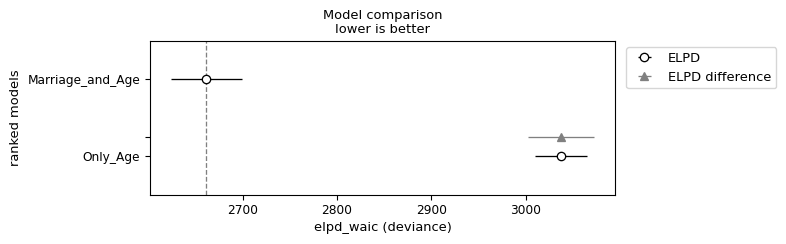

In [50]:
az.plot_compare(compare_data_7h4)

We already know based on the prior chapter that Including Marriage provides the incorrect causal inference because marriage is a collider.  However, including marriage should provide more accurate predictions.  Even including the error, Marriage and Age is clearly better than just Age.  Including marriage does provide us with more information by creating a relationship between age and hapiness, which leads to a better prediction, even if the causal relationship is incorrect.  From a causal perpsective, intervening on age will not change hapiness, even if the model that include marriage indicates that it will

# 7H5 Question
 Revisit the urban fox data, data(foxes), from the previous chapter’s practice problems. Use WAIC or PSIS based model comparison on five different models, each using weight as the outcome, and containing these sets of predictor variables:

1. avgfood + groupsize + area
2. avgfood + groupsize
3. groupsize + area
4. avgfood
5. area

Can you explain the relative differences in WAIC scores, using the fox DAG from the previous chapter? Be sure to pay attention to the standard error of the score differences (dSE).


In [51]:
#7h5
fox_data = pd.read_csv('./data/foxes.csv')
fox_data.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [52]:
fox_data_std = fox_data.copy()
fox_data_std.iloc[:,1:5] = fox_data_std.iloc[:,1:5].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
fox_data_std.head()

,group,avgfood,groupsize,area,weight
0,1,-1.924829,-1.524089,-2.239596,0.414135
1,1,-1.924829,-1.524089,-2.239596,-1.427046
2,2,-1.118035,-1.524089,-1.205508,0.675954
3,2,-1.118035,-1.524089,-1.205508,1.300942
4,3,-1.319734,-1.524089,-1.130106,1.115135


In [53]:
with pm.Model() as m_7h5_a:
    a = pm.Normal('a', 0, 0.2)
    b_area = pm.Normal('b_area', 0,0.5)
    b_gsize = pm.Normal('b_gsize', 0,0.5)
    b_food = pm.Normal('b_food', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_area * fox_data_std['area'] + b_gsize * fox_data_std['groupsize'] + b_food * fox_data_std['avgfood'] 
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_7h5_a_trace = pm.sample(idata_kwargs={"log_likelihood": True}) 

with pm.Model() as m_7h5_b:
    a = pm.Normal('a', 0, 0.2)
    b_gsize = pm.Normal('b_gsize', 0,0.5)
    b_food = pm.Normal('b_food', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_gsize * fox_data_std['groupsize'] + b_food * fox_data_std['avgfood'] 
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_7h5_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})  

with pm.Model() as m_7h5_c:
    a = pm.Normal('a', 0, 0.2)
    b_area = pm.Normal('b_area', 0,0.5)
    b_gsize = pm.Normal('b_gsize', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_area * fox_data_std['area'] + b_gsize * fox_data_std['groupsize']
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_7h5_c_trace = pm.sample(idata_kwargs={"log_likelihood": True}) 

with pm.Model() as m_7h5_d:
    a = pm.Normal('a', 0, 0.2)
    b_food = pm.Normal('b_food', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_food * fox_data_std['avgfood'] 
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_7h5_d_trace = pm.sample(idata_kwargs={"log_likelihood": True}) 

with pm.Model() as m_7h5_e:
    a = pm.Normal('a', 0, 0.2)
    b_area = pm.Normal('b_area', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_area * fox_data_std['area']
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_7h5_e_trace = pm.sample(idata_kwargs={"log_likelihood": True}) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_area, b_gsize, b_food, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_gsize, b_food, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_area, b_gsize, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_food, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_area, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [54]:
compare_data_7h5 = az.compare(
    {'Food_GroupSize_Area':m_7h5_a_trace,
      'Food_GroupSize':m_7h5_b_trace,
    'GroupSize_Area':m_7h5_c_trace,
    'Food':m_7h5_d_trace,
    'Area':m_7h5_e_trace},
           scale='deviance',
           ic='waic'
          )
compare_data_7h5

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Food_GroupSize_Area,0,322.622659,4.340135,0.000000,0.000000,15.430939,0.000000,True,deviance
Food_GroupSize,1,323.433133,3.422218,0.810475,0.515152,15.364107,3.359882,False,deviance
GroupSize_Area,2,323.521507,3.429624,0.898848,0.484848,15.053160,2.677908,True,deviance
Food,3,333.199472,2.238736,10.576813,0.000000,13.314191,6.636423,False,deviance
Area,4,333.507150,2.490507,10.884491,0.000000,13.286119,6.687547,False,deviance


d:\Python\venv\pymc_env\lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

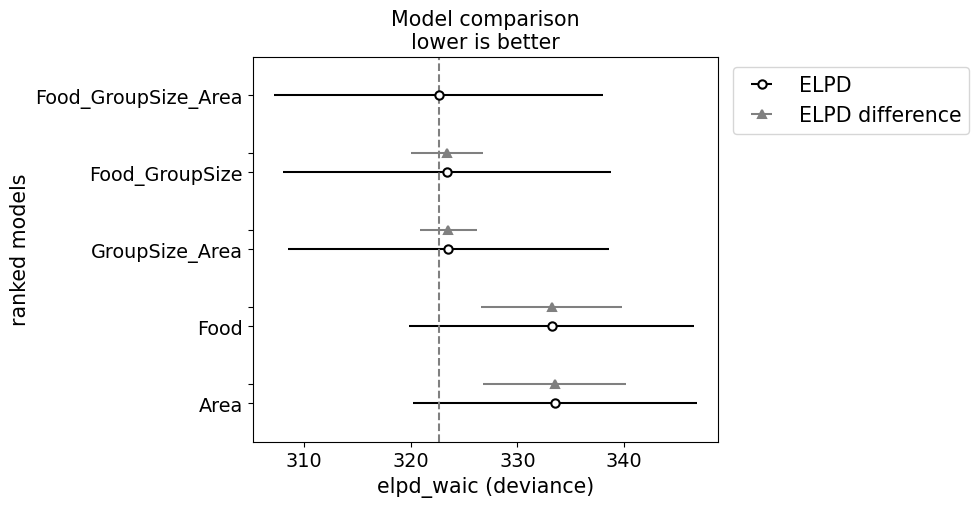

In [55]:
az.plot_compare(compare_data_7h5)

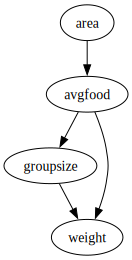

In [56]:
sevenH5 = CausalGraphicalModel(
    nodes = ['area','avgfood','groupsize','weight'],
    edges = [('area','avgfood'),
             ('avgfood','groupsize'),
             ('avgfood','weight'),
             ('groupsize','weight')])
sevenH5.draw()

We already know from HW6 that group size is masking the affect, since larger groups probably are able to catch more food, but it averages out since there are more foxes to feed.  So it makes sense that added group size reduces the WAIC, but the error bars are so wide there is a alot of overlap between all the WAIC.

Looking at the DAG, we can see that there are basically no backdoor paths from area or avgfood to weight.  So in the first 3 models, area and avgfood basically provide the same information, and the WAIC score is the same.  For the 4 and 5th model, it's the same situaion.  The WAIC score model only with avgfood is the similar to the model only with area because area is directly driving avgfood, so the models are very similar.